In [1]:
import sys
# sys.path.append('/work/westgroup/ChrisB/_04_thesis/rmg_thesis/RMG-Py/')
print(sys.path)

['/work/westgroup/ChrisB/_04_thesis/Thesis_repo/rmg_modification', '/work/westgroup/ChrisB/_04_thesis/rmg_thesis/RMG-Py', '/work/westgroup/ChrisB/_04_thesis/Thesis_repo/rmg_modification', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python37.zip', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python3.7', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python3.7/lib-dynload', '', '/home/blais.ch/.local/lib/python3.7/site-packages', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python3.7/site-packages', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python3.7/site-packages/chemprop-0.0.1-py3.7.egg', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python3.7/site-packages/descriptastorus-2.0.0.32-py3.7.egg', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python3.7/site-packages/IPython/extensions', '/home/blais.ch/.ipython']


In [2]:
import os
import shutil
import sys
import itertools

from rmgpy.chemkin import load_chemkin_file
from rmgpy.data.surface import MetalPropertyLibrary, SitePropertyLibrary, MetalPropertyDatabase, SitePropertyDatabase
from rmgpy.data.thermo import ThermoDatabase

## verify that the metalproperties databases load correctly

In [3]:
mpdb = MetalPropertyDatabase()
spdb = SitePropertyDatabase()
path = '/work/westgroup/ChrisB/_04_thesis/rmg_thesis/RMG-database/input/surface/'
mpdb.load(path)
spdb.load(path)

## check combinatorial number of sites possible

In [4]:
coords_111 = spdb.get_all_coordination_numbers_on_facet('111')
coords_100 = spdb.get_all_coordination_numbers_on_facet('100')

sites_111 = list(spdb.get_all_coordination_numbers_on_facet('111').keys())
list_of_sites = []
for item in itertools.combinations_with_replacement(sites_111, 2):
    list_of_sites.append(item)
list_of_sites

[('111_fcc_hollow', '111_fcc_hollow'),
 ('111_fcc_hollow', '111_hcp_hollow'),
 ('111_fcc_hollow', '111_bridge'),
 ('111_fcc_hollow', '111_top'),
 ('111_hcp_hollow', '111_hcp_hollow'),
 ('111_hcp_hollow', '111_bridge'),
 ('111_hcp_hollow', '111_top'),
 ('111_bridge', '111_bridge'),
 ('111_bridge', '111_top'),
 ('111_top', '111_top')]

In [5]:
# get the metal atom number for each site (number of metal atoms bound atom attaches to) 
metal_atom_number = spdb.get_all_metal_atoms_on_facet('111')
max_ma = max(metal_atom_number.values())
max_ma_site = [k for k, v in metal_atom_number.items() if v == max(metal_atom_number.values())]
cns_max_ma = {k:coords_111[k] for k in max_ma_site}
min(cns_max_ma, key=cns_max_ma.get)

'111_fcc_hollow'

# see which entries still need "site" defined

In [6]:
#load the thermodynamics database
thermoDatabase = ThermoDatabase()
libraries = ['surfaceThermoPt111']
if sys.platform == "darwin":
    thermoDatabase.load(path="/Users/blais.ch/Documents/_01_code/RMG_env_1/RMG-database/input/thermo", libraries = libraries)
else: 
    thermoDatabase.load(path='/work/westgroup/ChrisB/_04_thesis/rmg_thesis/RMG-database/input/thermo', libraries = libraries)

## see which sites we haven't Id'd

In [7]:
# search_str = ""
# show_no_site = True
# for key in sorted(thermoDatabase.libraries["surfaceThermoPt111"].entries.keys()):
#     if show_no_site and len(thermoDatabase.libraries["surfaceThermoPt111"].entries[key].site)>0:
#         continue
#     else:
#         if len(search_str) > 0 and search_str.lower() in key.lower():
#             print(f"\'{key}\': \'{thermoDatabase.libraries['surfaceThermoPt111'].entries[key].site}\'")
#         elif len(search_str) == 0: 
#             print(f"\'{key}\': \'{thermoDatabase.libraries['surfaceThermoPt111'].entries[key].site}\'")

$\theta = E_{ad} -0.1*\frac{X_{m}-X}{X_{m}+1}*\psi-0.2*\frac{X+1}{X_{m}+1}*\overline{CN}$

In [7]:
def get_adatom_site(species, metal_atoms1, cn_nums1, metal_atoms2, cn_nums2):
    """
    gets the adatoms, bond orders, and sites for a given species

    :param species: the adsorbate species
    :param metal_atoms: the number of metal atoms available on the surface
    :param cn_nums: the coordination numbers for the different sites on the surface
    :return: a list of tuples with the bound atom, site, bond order, and max bond order
    """
    sites = {}
    max_bond_orders = {'C': 4., 'O': 2., 'N': 3., 'H': 1.}

    for atom in species.molecule[0].atoms: 
        if atom.is_surface_site():
            # vdw check
            if len(atom.bonds) == 0:
                return None

            else:
                bound_atom = list(atom.bonds.keys())[0]
                # what do I do for bonds? see where it is used and if I can use total bonds for getting preferred site. 
                bonds = list(atom.bonds.values())[0].get_order_num()
                # max_bond_order = max_bond_orders[bound_atom.symbol]

                # Need to check if there are multiple functional groups attached
                # to a single atom. 
                groups_xm = []
                groups_x = []
                for atom, bond in bound_atom.bonds.items():
                    if bound_atom.symbol == 'C':
                        # check for OH, can have 5 bonds to C
                        if atom.is_oxygen() and bond.is_single():
                            groups_xm.append(5.)
                            groups_x.append(1)
                        else: 
                            groups_xm.append(4.)
                            groups_x.append(bond.get_order_num())
                    else: 
                        groups_xm.append(max_bond_orders[bound_atom.symbol])

                # this only works for 2 functional groups with a different 
                # max bond order. Gao does not define what to do with 3 or more. 
                if len(set(groups_xm)) > 1:
                    max_bo_group1 = max(groups_xm)
                    max_bo_group2 = min(groups_xm)


                if len(atom.site) > 0:
                    site = atom.site

                # if no site is specified, look at bond order and try to match 
                else:
                    # get max metal atoms available for the facet (e.g. 111 = 3 for hollow site) 
                    max_ma = max(metal_atoms.values())

                    if bound_atom.symbol == 'C':
                        pref_site = bonds
                    elif bound_atom.symbol == 'O': 
                        pref_site = bonds + 1
                    elif bound_atom.symbol == 'N': 
                        pref_site = bonds + 1
                    elif bound_atom.symbol == 'H':
                        pref_site = 1

                    # if the preference is higher than the largest num of metal atoms, 
                    # then just go to the site with most available metal atoms
                    # print(pref_site, max_site)
                    if pref_site > max_ma:
                        pref_site = max_ma

                    # get all possible sites on the surface
                    poss_sites = []
                    for poss_site, ma_num in metal_atoms.items():
                        if pref_site == ma_num: 
                            poss_sites.append(poss_site)
                    print("poss_sites ", poss_sites)

                    # if multiple suitable sites are found, use one with lowest coordination number 
                    if len(poss_sites) == 1:
                        site = poss_sites[0]

                    if len(poss_sites) > 1:
                        ma_site = [k for k, v in metal_atoms.items() if v == pref_site]

                        # get the coordination numbers corresponding to the max ma sites
                        cns_ma = {k:coords_111[k] for k in ma_site}
                        site = min(cns_max_ma, key=cns_max_ma.get)

                    # no sites found, see if it is larger than max sites. 
                    elif len(poss_sites) == 0: 
                        raise ValueError(f"no site could be found for bound atom {bound_atom.symbol} in species {species.label}")


                print(f"preferred site for {bound_atom.symbol} is {site} with {pref_site} metal atoms")

            sites[atom] = {"site1": site1, "bonds": bonds, "max_bond_order": max_bond_order,
                           "site2": site2, }

    return sites

def correct_binding_energies_extended(thermo, species, metal_to_scale_from=None,
                                    metal_to_scale_to=None, facet_to_scale_from=None, facet_to_scale_to=None):
    """
    Uses the binding energy correction proposed by gao, which allows for scaling
    from one metal and facet (e.g. Pt111) to a completely different metal and 
    facet (e.g. Cu111). 

    :param thermo: the thermo data to correct
    :param species: the species to correct
    :param metal_to_scale_from: the metal to scale from (e.g. Pt)
    :param metal_to_scale_to: the metal to scale to (e.g. Cu)
    :param facet_to_scale_from: the facet to scale from (e.g. 111)
    :param facet_to_scale_to: the facet to scale to (e.g. 111)
    :return: the corrected thermo data

    """

    if metal_to_scale_from == metal_to_scale_to and facet_to_scale_from == facet_to_scale_to:
        return thermo
    elif metal_to_scale_from is None or metal_to_scale_to is None or facet_to_scale_from is None or facet_to_scale_to is None:
        raise ValueError("If you are scaling, you must specify both the metal and the facet to scale from and to.")

    # get the required attributes for every facet and metal involved
    cn1_dict = thermoDatabase.surface['site_properties'].get_all_coordination_numbers_on_facet(facet_to_scale_from)
    cn2_dict = thermoDatabase.surface['site_properties'].get_all_coordination_numbers_on_facet(facet_to_scale_to)

    ma1_dict = thermoDatabase.surface['site_properties'].get_all_metal_atoms_on_facet(facet_to_scale_from)
    ma2_dict = thermoDatabase.surface['site_properties'].get_all_metal_atoms_on_facet(facet_to_scale_to)

    psi1 = thermoDatabase.surface['metal_properties'].get_psi(metal_to_scale_from)
    psi2 = thermoDatabase.surface['metal_properties'].get_psi(metal_to_scale_to)

    # determine the preferred sites for the species on each surface
    # only call once so we can link the sites
    surf_sites = thermoDatabase.get_adatom_site(species, ma1_dict, cn1_dict, ma2_dict, cn2_dict)
    # surf2_sites = thermoDatabase.get_adatom_site(species,ma2_dict,cn2_dict)

    # check for non_surface_species or vdw
    if not surf1_sites or len(surf1_sites) == 0: 
        print(f"species {species.label} has no sites")
        print(thermo.H298.value_si/9.68e4)
        return thermo

    # print for logging
    metal1_str = f"{metal_to_scale_from}({facet_to_scale_from})"
    metal2_str = f"{metal_to_scale_to}({facet_to_scale_to})"
    print(f"scaling species {species.label} on {metal1_str} at site(s) {surf1_sites} to {metal2_str} at site(s) {surf2_sites}")

    theta = 0
    E_ads_new = 0

    # 1. get theta with known values
    comments = []
    for bound_atom, site, X, X_m in surf1_sites: 
        cn = cn1_dict[site]
        E_ad = (thermo.H298.value_si)/9.68e4

        # for multidentates, we will use the same strategy as lsrs. calculate 
        # the theta additively for each site
        theta += E_ad-0.1*(X_m-X)/(X_m+1)*psi1-0.2*(X+1)/(X_m+1)*cn
        comments.append(f"{bound_atom} on {metal1_str} at {site} order={X/X_m:.2f}")

    # 2. get new adsorption energy
    for bound_atom, site, X, X_m in surf2_sites: 
        cn = cn2_dict[site]

        E_ads_new += 0.1*(X_m-X)/(X_m+1)*psi2+0.2*(X+1)/(X_m+1)*cn + theta
        comments.append(f"{bound_atom} on {metal2_str} at {site} order={X/X_m:.2f}")

    thermo.comment += " Binding energy corrected by Gao relations ({})".format(', '.join(comments))

    # update the species metal and facet

    # adjust the H298
    thermo.H298.value_si = E_ads_new*9.68e4
    print(f"scaling species {species.label} to {E_ads_new} with theta {theta}")

    return thermo

## Test with OH from Pt111 to Rh211

In [ ]:
# test the function. load model each time 
folder = './test_mech/chemkin/'

chemkin_path = os.path.join(folder, 'chem_annotated-gas.inp')
chemkin_surf_path = os.path.join(folder, 'chem_annotated-surface.inp')
dictionary_path = os.path.join(folder, 'species_dictionary.txt')

# load_chemkin_file
species, reactions = load_chemkin_file(chemkin_surf_path, dictionary_path)
# identify a surface species to use for testing
surf_species = species[5]
surf_species.generate_resonance_structures()
display(surf_species)
spec_thermo = surf_species.thermo.to_thermo_data()
surf_species.thermo = spec_thermo
thermo_list = thermoDatabase.get_all_thermo_data(surf_species)
E_ad_old = (spec_thermo.H298.value_si)/9.68e4

new_thermo = correct_binding_energies_extended(spec_thermo, surf_species, metal_to_scale_from='Pt',
                                       metal_to_scale_to='Rh', facet_to_scale_from='111', facet_to_scale_to='211')
print("old E_ad = ", E_ad_old)
print(new_thermo.comment)

## test with O


In [19]:
print(spec_thermo.comment)

Thermo library: surfaceThermoNi111 Binding energy corrected by LSR (0.50O) from Ni111 Binding energy corrected by Gao relations (O on Pt(111) at 111_bridge order=0.50, O on Rh(211) at 211_100_edge_bridge order=0.50)


In [20]:
# test the function. load model each time 
folder = './test_mech/chemkin/'

chemkin_path = os.path.join(folder, 'chem_annotated-gas.inp')
chemkin_surf_path = os.path.join(folder, 'chem_annotated-surface.inp')
dictionary_path = os.path.join(folder, 'species_dictionary.txt')

# load_chemkin_file
species, reactions = load_chemkin_file(chemkin_surf_path, dictionary_path)

surf_species = species[2]
surf_species.generate_resonance_structures()
display(surf_species)
spec_thermo = surf_species.thermo.to_thermo_data()
surf_species.thermo = spec_thermo



E_ad_old = (spec_thermo.H298.value_si)/9.68e4
print("1: ",spec_thermo.H298.value_si/9.68e4)
new_thermo  = correct_binding_energies_extended(spec_thermo, surf_species, metal_to_scale_from='Pt',
                                       metal_to_scale_to='Rh', facet_to_scale_from='111', facet_to_scale_to='211')

print("old E_ad = ", E_ad_old,new_thermo.H298.value_si/9.68e4)

1:  -2.2753166768898305


poss_sites  ['111_fcc_hollow', '111_hcp_hollow']
preferred site for O is 111_fcc_hollow with 3.0 metal atoms
poss_sites  ['211_hollow']
preferred site for O is 211_hollow with 3.0 metal atoms
scaling species OX to -2.48431667688983 with theta -3.6663166768898305
old E_ad =  -2.2753166768898305 -2.48431667688983


## test with vdw species

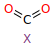

1:  -4.442293568472368


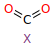

species CO2X has no sites
-4.442293568472368
old E_ad =  -4.442293568472368 -4.442293568472368


In [25]:
# test the function. load model each time 
folder = './test_mech/chemkin/'

chemkin_path = os.path.join(folder, 'chem_annotated-gas.inp')
chemkin_surf_path = os.path.join(folder, 'chem_annotated-surface.inp')
dictionary_path = os.path.join(folder, 'species_dictionary.txt')

# load_chemkin_file
species, reactions = load_chemkin_file(chemkin_surf_path, dictionary_path)

surf_species = species[6]
surf_species.generate_resonance_structures()
display(surf_species)
spec_thermo = surf_species.thermo.to_thermo_data()
surf_species.thermo = spec_thermo



E_ad_old = (spec_thermo.H298.value_si)/9.68e4
print("1: ",spec_thermo.H298.value_si/9.68e4)
new_thermo  = correct_binding_energies_extended(spec_thermo, surf_species, metal_to_scale_from='Pt',
                                       metal_to_scale_to='Rh', facet_to_scale_from='111', facet_to_scale_to='211')

print("old E_ad = ", E_ad_old,new_thermo.H298.value_si/9.68e4)

9 HOCXO


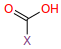

In [34]:
## get second order bonds from carbon in cooh
for num, spec in enumerate(species):
    if "HOCXO" in spec.label:
        print(num, spec.label)
        display(spec)


In [48]:
surf_spec = species[9]
for atom,bond in surf_spec.molecule[0].atoms[2].bonds.items():
    if atom.is_oxygen() and bond.is_single():
        print(atom, bond)

O S


In [51]:
surf_spec.to_adjacency_list()

'HOCXO\n1 O u0 p2 c0 {3,S} {4,S}\n2 O u0 p2 c0 {3,D}\n3 C u0 p0 c0 {1,S} {2,D} {5,S}\n4 H u0 p0 c0 {1,S}\n5 X u0 p0 c0 {3,S}\n'